In [1]:
cd ../

/nfs/home/dgranziol/kfac-curvature


In [53]:
import argparse
import time
import tabulate

import numpy as np

from gpytorch.utils.lanczos import lanczos_tridiag

import torch

from curvature import data, models, losses, utils
from curvature.methods.swag import SWAG

In [54]:
model = 'VGG16'
print('Using model %s' % model)
model_cfg = getattr(models,model)

Using model VGG16


In [55]:
dataset = 'CIFAR100'
data_path = '/nfs/home/dgranziol/curvature/data'
ckpt = '/nfs/home/dgranziol/curvature/ckpts/c100/VGG16/SGDOPT/checkpoint-00300.pt'
iters = 10

In [56]:
batch_size = 1024

datasets, num_classes = data.datasets(
    dataset,
    data_path,
    transform_train=model_cfg.transform_test,
    transform_test=model_cfg.transform_test,
    use_validation=False,
    train_subset=None,
    train_subset_seed=None,
)
loader = torch.utils.data.DataLoader(
    datasets['train'],
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
full_datasets, _ = data.datasets(
    dataset,
    data_path,
    transform_train=model_cfg.transform_train,
    transform_test=model_cfg.transform_test,
    use_validation=not False,
)
full_loader = torch.utils.data.DataLoader(
    full_datasets['train'],
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Loading CIFAR100 from /nfs/home/dgranziol/curvature/data
Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified
Using train (50000) + test (10000)
Loading CIFAR100 from /nfs/home/dgranziol/curvature/data
Files already downloaded and verified
Using 5000 samples for validation [deterministic split]
Files already downloaded and verified
Using train (45000) + test (5000)


In [57]:
model = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
print('Loading %s' % ckpt)
checkpoint = torch.load(ckpt)
model.load_state_dict(checkpoint['state_dict'])

Loading /nfs/home/dgranziol/curvature/ckpts/c100/VGG16/SGDOPT/checkpoint-00300.pt


<All keys matched successfully>

In [58]:
if torch.cuda.is_available():
   device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device)
num_parametrs = sum([p.numel() for p in model.parameters()])
criterion = losses.cross_entropy


In [59]:
covgrad = utils.covgrad(loader, model, criterion, cuda='cuda' == 'cuda', bn_train_mode=False)

RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 10.76 GiB total capacity; 6.10 GiB already allocated; 164.06 MiB free; 731.31 MiB cached)

In [ ]:
np_covgrad = covgrad['covgrad_mat'].numpy()
K = np.matrix(np_covgrad)
covariance = np.matmul(K,K.transpose())
C = np.linalg.svd((batch_size/covgrad['num_batches'])*covariance, full_matrices=True)

In [ ]:
covgrad['num_batches']

In [48]:
print(max(C[1]))
print(max(C[1])*covgrad['num_batches'])

7.306655609858918
716.052249766174


In [49]:
a = np.sort(C[1])
print(a[len(a)-1])
print(a[len(a)-2])
print(a[len(a)-3])
print(a[len(a)-4])

7.306655609858918
5.751960503784982
3.4485000647295165
2.573879602448394


In [23]:
a = np.sort(C[1])
print(a[len(a)-1])
print(a[len(a)-2])
print(a[len(a)-3])
print(a[len(a)-4])

6.339800553908807
3.8506211975953324
2.4313381917855095
2.223034995889413


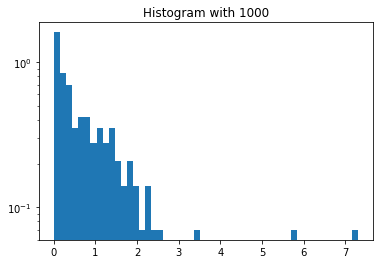

In [51]:
import matplotlib.pyplot as plt
_ = plt.hist(C[1], bins=50, density=True)  # arguments are passed to np.histogram
plt.yscale('log')
plt.title("Histogram with 1000")
plt.show()

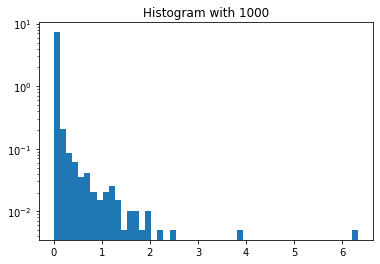

In [27]:
import matplotlib.pyplot as plt
_ = plt.hist(C[1], bins=50, density=True)  # arguments are passed to np.histogram
plt.yscale('log')
plt.title("Histogram with 1000")
plt.show()

In [52]:
%reset -f 

In [ ]:
class CurvVecProduct(object):
    def __init__(self, loader, model, criterion, curvature_matrix, full_loader=None):
        self.loader = loader
        self.full_loader = full_loader
        self.model = model
        self.criterion = criterion
        self.iters = 0
        self.timestamp = time.time()
        self.curvature_matrix = curvature_matrix

    def __call__(self, vector):
        start_time = time.time()
        if self.curvature_matrix == 'hessian':
            output = utils.hess_vec(
                vector,
                self.loader,
                self.model,
                self.criterion,
                cuda='cuda'
               
                )
        elif self.curvature_matrix == 'covgrad':
            output = utils.covgrad_vec(
                vector,
                self.loader,
                self.model,
                self.criterion,
                cuda='cuda',
            )
        else:
            raise ValueError("Unrecognised curvature_matrix argument "+self.curvature_matrix)
        time_diff = time.time() - start_time

        self.iters += 1
        print('Iter %d. Time: %.2f' % (self.iters, time_diff))
        # return output.unsqueeze(1)¬
        return output.cpu().unsqueeze(1)

w = torch.cat([param.detach().cpu().view(-1) for param in model.parameters()])
w_l2_norm = torch.norm(w).numpy()
w_linf_norm = torch.norm(w, float('inf')).numpy()

In [ ]:
# #Hessian
# productor = CurvVecProduct(loader, model, criterion, 'hessian')
# utils.bn_update(full_loader, model)
# Q, T = lanczos_tridiag(productor, 2, dtype=torch.float32, device='cpu', matrix_shape=(num_parametrs, num_parametrs))

# eigvals, eigvects = T.eig(eigenvectors=True)
# gammas = eigvects[0, :] ** 2
# V = eigvects.t() @ Q.t()

In [ ]:
# eigvals

In [ ]:
#covgrad
productor = CurvVecProduct(loader, model, criterion, 'covgrad')
utils.bn_update(full_loader, model)
Q, T = lanczos_tridiag(productor, 10, dtype=torch.float32, device='cpu', matrix_shape=(num_parametrs, num_parametrs))

eigvals, eigvects = T.eig(eigenvectors=True)
gammas = eigvects[0, :] ** 2
V = eigvects.t() @ Q.t()

In [ ]:
eigvals

In [ ]:
a = torch.rand(1)
print(a)
print(a.item())
b = torch.rand(3,4)
print(b)
c = torch.rand(5,6)
f = [b,c]
print('fold')
print(f)
print('thingy')
for j in f:
    print(j*a)
new_list = [j*a for j in f]
print(new_list)


In [ ]:
py_list = [[1.,2.,3.,4.],[5.,6.,7.,8.],[9.,10.,11.,12.]]
print(torch.FloatTensor(py_list))

In [ ]:
print(f)
g = torch.zeros(15291300)
offset = 0
for i in range(0,len(f)):
    k = f[i].reshape(-1)
    g[offset:offset+len(k)] = k
    offset = offset +len(k)
print(g)

In [ ]:
print(offset)

In [ ]:
a.reshape(-1)

In [ ]:
hess = utils.hess_vec(torch.rand(15291300),loader,model,criterion)

In [ ]:
len(hess)

In [ ]:
covgrad = utils.covgrad_vec(torch.rand(15291300),loader,model,criterion)

In [ ]:
print(hess)
print(len(hess))
print(covgrad)
print(len(covgrad))

In [ ]:
vector = torch.rand(15291300)
vector_list = []
offset = 0
for param in param_list:
    vector_list.append(vector[offset:offset + param.numel()].detach().view_as(param).to(param.device))
    offset += param.numel()

In [ ]:
print(vector)
print(vector_list[0:1])
#print(vector_list)

In [ ]:
#param_list = list(model.parameters())
for param in param_list:
    print(param)

In [ ]:
# vector = []
# param_list = list(model.parameters())
# vector_list = []
# # vector_list2 = []

# offset = 0
# for param in param_list:
#     vector_list.append(vector[offset:offset + param.numel()].detach().view_as(param).to(param.device))
#     offset += param.numel()

# # vector2 = torch.zeros_like(vector)
# # for param in param_list:
# #     vector_list2.append(vector2[offset:offset + param.numel()].detach().view_as(param).to(param.device))
# #     offset += param.numel()

# vector_list2 = torch.zeros_like(vector)

# model.eval()
# if bn_train_mode:
#     model.apply(_bn_train_mode)

# model.zero_grad()
# N = len(loader.dataset)
# for input, target in loader:
#     if cuda:
#         input = input.cuda(non_blocking=True)
#         target = target.cuda(non_blocking=True)
#     loss, _, _ = criterion(model, input, target)
#     loss *= input.size()[0] / N

#     grad_list = torch.autograd.grad(loss, param_list, create_graph=True)

#     dL_dvec = torch.zeros(1)
#     if cuda:
#         dL_dvec = dL_dvec.cuda()
#         vector_list2.cuda()
#     for v, g in zip(vector_list, grad_list):
#         dL_dvec += torch.sum(v * g)
#     dL_dvec *= grad_list
#     vector_list2 += dL_dvec
#     #dL_dvec.backward()
#     #print(param_list[0].grad.size())
# model.eval()